## **Data Gathering and Cleansing**

In [49]:
import pandas as pd
import requests

#### Fetch 1000 restaurants from Yelp API <br> Yelp API has a limitation that only allows exporting 1000 places <br>https://docs.developer.yelp.com/reference/v3_business_search

In [ ]:
headers = {
    "accept": "application/json",
    "Authorization": "Bearer "
}

all_data = [] 
offset = 0
limit = 50

# Set a limit to iterate through
while offset < 1000:
    url = f"https://api.yelp.com/v3/businesses/search?location=Louisville%2C%20KY&term=restaurant&sort_by=best_match&limit={limit}&offset={offset}"
    print(url)

    response = requests.get(url, headers=headers)
    data = response.json()
    
    # Append the 'businesses' data to the list
    all_data.extend(data['businesses'])

    offset += limit

# Convert the list of dictionaries to a DataFrame
df = pd.json_normalize(all_data)  

# Output Yelp API results to excel
df.to_excel("yelp_places.xlsx", index=False)

#### Read yelp_places.xlsx to dataframe<br> 
Convert all characters to lowercase (to eventually perform join/merge)

In [ ]:
yelp_df = pd.read_excel("yelp_places.xlsx")
yelp_df = yelp_df.applymap(lambda s: s.lower() if type(s) == str else s)
# yelp_df

#### Read louisville_inspection.xlsx file to dataframe 
Convert all characters to lowercase (to eventually perform join/merge)

In [54]:
lou_inspection = pd.read_excel("louisville_inspection.xlsx")
lou_inspection.columns = lou_inspection.columns.str.lower()
lou_inspection = lou_inspection.applymap(lambda s: s.lower() if type(s) == str else s)
# lou_inspection

#### Merge dataframes to make a single dataframe <br> Drop columns

In [59]:
merged_df = pd.merge(lou_inspection,yelp_df, left_on=['establishmentname','address'], right_on=['name','location.address1'])
merged_df.drop(columns=['address2','city','state','namesearch','intersection','objectid','id','alias',\
                     'name', 'is_closed','image_url','url','categories','transactions','phone','display_phone','distance',\
                     'coordinates.latitude','coordinates.longitude','location.address2','location.address3',\
                     'location.city','location.zip_code','location.country','location.state','location.display_address','location.address1','placename','address','typedescription'], inplace=True)
# merged_df.to_excel("merged_output.xlsx", index=False)
# merged_df

##### ONLY return records where score != 0

In [ ]:
mask = merged_df['score'] != 0
merged_df_masked = merged_df[mask]
merged_df_masked
# merged_df_masked.to_excel("merged_output_masked.xlsx", index=False)

#### Output data into queryable table (SQLite)

In [ ]:
# come back if I have time

## **Visualizations**

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [61]:
louisville_zip_map = gpd.read_file(r'shapefile/Jefferson_County_KY_ZIP_Codes.shp')
# louisville_zip_map['ZIPCODE_length'] = louisville_zip_map['ZIPCODE'].astype(str).str.len()
louisville_zip_map.sort_values(by='ZIPCODE')
louisville_zip_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   42 non-null     int64   
 1   ZIPCODE    42 non-null     object  
 2   SHAPEAREA  42 non-null     float64 
 3   SHAPELEN   42 non-null     float64 
 4   geometry   42 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 1.8+ KB


#### Is there distribution of inspections across Jefferson County?

C:\Users\Mary's PC\AppData\Local\Temp\ipykernel_33992\2358243035.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged_map.geometry.centroid.x, merged_map.geometry.centroid.y, merged_map.ZIPCODE):


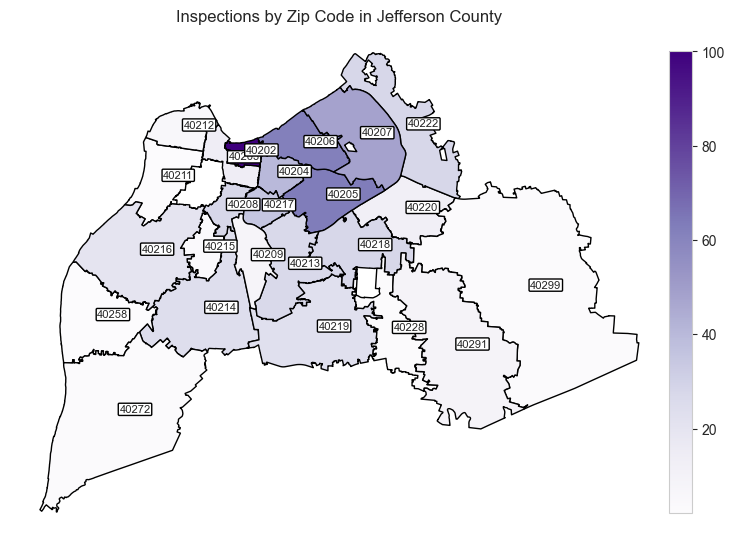

In [65]:
# path = "merged_output_masked.xlsx"
# os.path.join('..','merged_output_masked.xlsx')
# merged_df_masked = pd.read_excel(path)
louisville_data = merged_df_masked.copy()
louisville_data = louisville_data['zip'].value_counts().reset_index().rename(columns={'zip':'ZIPCODE'}).astype(str).sort_values(by='ZIPCODE')
# merged_df_masked['ZIPCODE_length'] = merged_df_masked['ZIPCODE'].astype(str).str.len()
louisville_data['count']=louisville_data['count'].astype(int)
# merged_df_masked.info()

merged_map = louisville_zip_map.merge(louisville_data,on='ZIPCODE')
# merged_map.info()
fig, ax = plt.subplots(figsize=(10, 10))


merged_map.plot(column='count', cmap='Purples', ax=ax, edgecolor='black', legend=True, legend_kwds={'location': 'right', 'pad': 0, 'shrink':0.6}).axis('off')

for x, y, label in zip(merged_map.geometry.centroid.x, merged_map.geometry.centroid.y, merged_map.ZIPCODE):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points",fontsize=8,
                bbox=dict(boxstyle="round, pad=0.1", fc="white", ec="black"))


plt.title("Inspections by Zip Code in Jefferson County")
plt.show()


#### Pairplot

C:\Users\Mary's PC\AppData\Local\Temp\ipykernel_33992\3430328955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_masked['cost_indicator'] = merged_df_masked['price'].map(cost_indicator).astype(float)


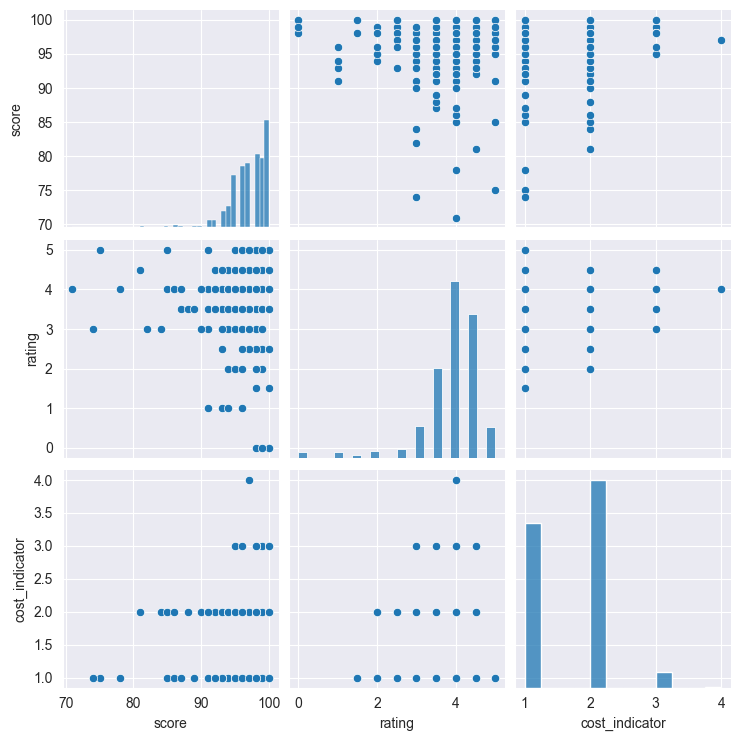

In [69]:
sns.set_style('darkgrid')

# The $-$$$$ system indicates cost per person to signify how much a customer should expect to spend
# Convert this "cost_indicator" because code was failing when attempting to read '$'
cost_indicator = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
merged_df_masked['cost_indicator'] = merged_df_masked['price'].map(cost_indicator).astype(float)

columns_to_compare = ['score', 'rating', 'cost_indicator']
sns.pairplot(merged_df_masked[columns_to_compare])
plt.show()

<Axes: xlabel='score', ylabel='rating'>

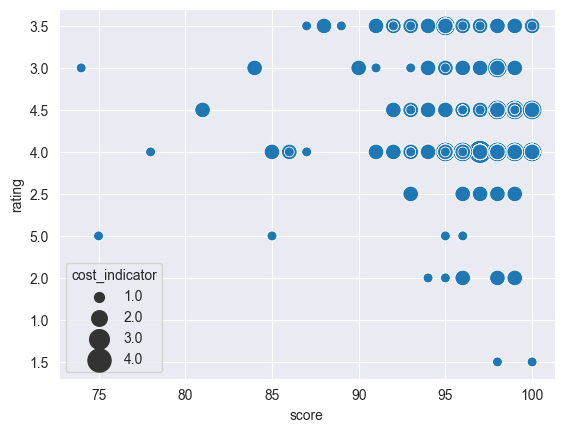

In [70]:
# pd.set_option('display.max_rows', None)

scatterplot_df = merged_df_masked.copy()
scatterplot_df['rating'] = scatterplot_df['rating'].astype(str)
# scatterplot_df.info()
sns.scatterplot(x='score', y='rating', 
                size='cost_indicator', 
                sizes=[50,125,200,275],
                data=scatterplot_df)

<Axes: >

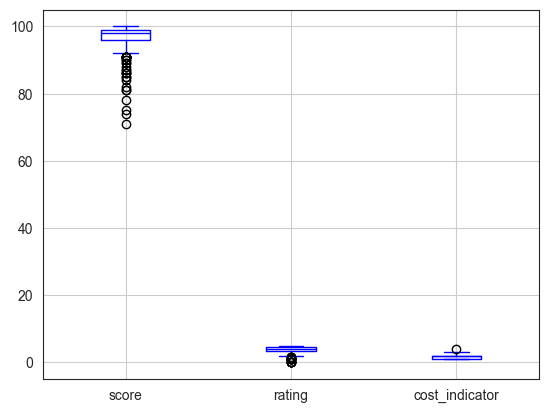

In [92]:
sns.set_style('white')
merged_df_masked.boxplot(column=['score', 'rating', 'cost_indicator'], color='blue',fontsize=10)


### Analysis Notes

1. There is a large concentration of inspections in specific regions of Jefferson County
2. Based on the pairplot, scatterplot, and boxplot there's really not much distribution in this data altogether
3. I wish that I can get my hands on year over year inspections 